# Prerequisites
### Import statements

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from PIL import Image
import tensorflow_datasets as tfds

### Check for GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Baseline: Global model with centralized data

## Load and prepare dataset (Industrial Quality Control of Packages)
### Load training data set consisting of data from all clients

In [ ]:
batch_size = 10000 #Set batch size to large number so that all images are processed in one batch

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='drive/MyDrive/data/all_clients', # complete data set can be found here: https://www.kaggle.com/christianvorhemus/industrial-quality-control-of-packages
  validation_split=0.2,
  subset="training",
  image_size=(224,224), 
  shuffle=True,
  seed=123,
  batch_size=batch_size)

Found 360 files belonging to 2 classes.
Using 288 files for training.


### Load validation data

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='drive/MyDrive/data/all_clients',
  validation_split=0.2,
  subset="validation",
  image_size=(224,224), 
  shuffle=True,
  seed=123,
  batch_size=batch_size)

Found 360 files belonging to 2 classes.
Using 72 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['damaged', 'intact']


### Load test data set (global holdout data set)

In [ ]:
batch_size = 10000 #Set batch size to large number so that all images are processed in one batch

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='drive/MyDrive/data/test_data', #data can be found here: https://www.kaggle.com/christianvorhemus/industrial-quality-control-of-packages
  image_size=(224,224), 
  shuffle=True,
  seed=123,
  batch_size=batch_size)

Found 40 files belonging to 2 classes.


### Plot images

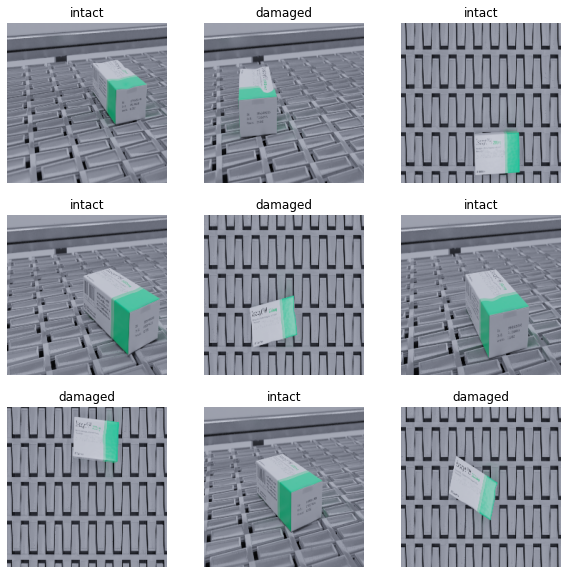

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

### Convert BatchDataset to Numpy arrays

In [ ]:
x_train = None
y_train = None

for image, label in tfds.as_numpy(train_ds):
    print("Labels: ", label)
    print("Number of labels: ", len(label))
    x_train = image
    y_train = label


Labels:  [1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1
 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0
 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0
 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0
 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0
 1 1 1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1
 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0]
Number of labels:  288


In [ ]:
x_train.shape

(288, 224, 224, 3)

In [ ]:
y_train.shape

(288,)

In [ ]:
x_val = None
y_val = None

for image, label in tfds.as_numpy(val_ds):
    print("Labels: ", label)
    print("Number of labels: ", len(label))
    x_val = image
    y_val = label

Labels:  [1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1]
Number of labels:  72


In [ ]:
x_test = None
y_test = None

for image, label in tfds.as_numpy(test_ds):
    print("Labels: ", label)
    print("Number of labels: ", len(label))
    x_test = image
    y_test = label

Labels:  [1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0
 0 1 1]
Number of labels:  40


### Adjust shape of labels

In [ ]:
y_train = np.reshape(y_train, (-1, 1))
y_val = np.reshape(y_val, (-1,1))
y_test = np.reshape(y_test, (-1,1))

In [ ]:
y_train.shape

(288, 1)

### Normalize images

In [ ]:
# Rescale to [0,1]
#x_train /= 255
#x_val /= 255

## Train classifier
### Try different models

### Load EfficientNet

In [ ]:
#model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), weights=None, classes=2)

### Build own model

In [ ]:
#model = Sequential()
#model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
#model.add(MaxPool2D())

#model.add(Conv2D(32, 3, padding="same", activation="relu"))
#model.add(MaxPool2D())

#model.add(Conv2D(64, 3, padding="same", activation="relu"))
#model.add(MaxPool2D())
#model.add(Dropout(0.4))

#model.add(Flatten())
#model.add(Dense(128,activation="relu"))
#model.add(Dense(2, activation="softmax"))

#model.summary()

### Load VGG16

In [ ]:
#model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), weights=None, classes=2)

### Fine-tune EfficientNet

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet", classes=2)

base_model.trainable = True

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2,activation="softmax")(x)
model = keras.Model(inputs, outputs)



16711680/16705208 [==============================] - 0s 0us/step


### Compile and train model

In [ ]:
epochs = 20

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = model.fit(x=x_train, y=y_train, batch_size=12, epochs=epochs, shuffle=True, validation_data=(x_val, y_val))

Epoch 1/20
24/24 [==============================] - 45s 324ms/step - loss: 0.7063 - accuracy: 0.5104 - val_loss: 0.6977 - val_accuracy: 0.4444
Epoch 2/20
24/24 [==============================] - 6s 255ms/step - loss: 0.6749 - accuracy: 0.5660 - val_loss: 0.6889 - val_accuracy: 0.5694
Epoch 3/20
24/24 [==============================] - 6s 256ms/step - loss: 0.6539 - accuracy: 0.6042 - val_loss: 0.6559 - val_accuracy: 0.6111
Epoch 4/20
24/24 [==============================] - 6s 257ms/step - loss: 0.6296 - accuracy: 0.6736 - val_loss: 0.6328 - val_accuracy: 0.6250
Epoch 5/20
24/24 [==============================] - 6s 256ms/step - loss: 0.5993 - accuracy: 0.7014 - val_loss: 0.6189 - val_accuracy: 0.7083
Epoch 6/20
24/24 [==============================] - 6s 256ms/step - loss: 0.5782 - accuracy: 0.7257 - val_loss: 0.5825 - val_accuracy: 0.7222
Epoch 7/20
24/24 [==============================] - 6s 255ms/step - loss: 0.5436 - accuracy: 0.7604 - val_loss: 0.5613 - val_accuracy: 0.7361
Epoch

### Plot training and validation accuracy

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

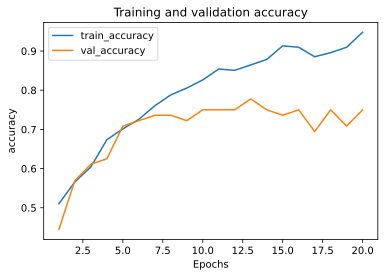

In [ ]:
plot_metric(history, 'accuracy')

### Evaluate centralized model on test data

In [ ]:
score = model.evaluate(x=x_test, y=y_test)

2/2 [==============================] - 3s 488ms/step - loss: 0.5890 - accuracy: 0.7500


In [ ]:
print('Accuracy: ', score[1])

Accuracy:  0.75


# Baseline: One model per client

### Load data of Client 1

In [ ]:
batch_size = 10000 #Set batch size to large number so that all images are processed in one batch

train_ds_client1 = tf.keras.preprocessing.image_dataset_from_directory(
  directory='drive/MyDrive/data/client1', 
  validation_split=0.2,
  subset="training",
  image_size=(224,224), 
  shuffle=True,
  seed=123,
  batch_size=batch_size)

val_ds_client1 = tf.keras.preprocessing.image_dataset_from_directory(
  directory='drive/MyDrive/data/client1',
  validation_split=0.2,
  subset="validation",
  image_size=(224,224), 
  shuffle=True,
  seed=123,
  batch_size=batch_size)



Found 120 files belonging to 2 classes.
Using 96 files for training.
Found 120 files belonging to 2 classes.
Using 24 files for validation.


### Prepare data

In [ ]:
  x_train_client1 = None
  y_train_client1 = None
  for image, label in tfds.as_numpy(train_ds_client1):
      x_train_client1 = image
      y_train_client1 = label

  x_val_client1 = None
  y_val_client1 = None
  for image, label in tfds.as_numpy(val_ds_client1):
      x_val_client1 = image
      y_val_client1 = label

  # Adjust shape of labels
  y_train_client1 = np.reshape(y_train_client1, (-1, 1))
  y_val_client1 = np.reshape(y_val_client1, (-1, 1))

### Fine-tune EfficientNet

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet", classes=2)

base_model.trainable = True

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2,activation="softmax")(x)
model = keras.Model(inputs, outputs)



### Compile and train model

In [ ]:
epochs = 20

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = model.fit(x=x_train_client1, y=y_train_client1, batch_size=12, epochs=epochs, shuffle=True, validation_data=(x_val_client1, y_val_client1))

Epoch 1/20
8/8 [==============================] - 12s 522ms/step - loss: 0.7857 - accuracy: 0.4896 - val_loss: 0.6559 - val_accuracy: 0.7083
Epoch 2/20
8/8 [==============================] - 2s 270ms/step - loss: 0.6736 - accuracy: 0.5417 - val_loss: 0.8608 - val_accuracy: 0.2917
Epoch 3/20
8/8 [==============================] - 2s 270ms/step - loss: 0.6552 - accuracy: 0.6042 - val_loss: 0.8534 - val_accuracy: 0.3750
Epoch 4/20
8/8 [==============================] - 2s 264ms/step - loss: 0.6258 - accuracy: 0.7083 - val_loss: 0.8080 - val_accuracy: 0.3750
Epoch 5/20
8/8 [==============================] - 2s 265ms/step - loss: 0.6100 - accuracy: 0.7188 - val_loss: 0.7544 - val_accuracy: 0.3750
Epoch 6/20
8/8 [==============================] - 2s 263ms/step - loss: 0.5887 - accuracy: 0.7188 - val_loss: 0.7836 - val_accuracy: 0.3750
Epoch 7/20
8/8 [==============================] - 2s 262ms/step - loss: 0.5713 - accuracy: 0.7292 - val_loss: 0.8066 - val_accuracy: 0.3750
Epoch 8/20
8/8 [===

### Plot training and validation accuracy

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

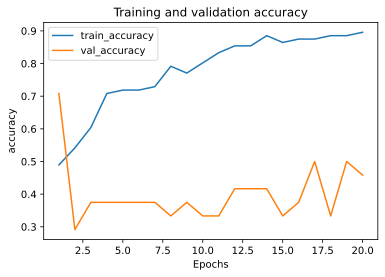

In [ ]:
plot_metric(history, 'accuracy')

### Evaluate local model of Client 1 on test data

In [ ]:
score = model.evaluate(x=x_test, y=y_test)
print('Accuracy of local model (Client 1): ', score[1])

2/2 [==============================] - 2s 53ms/step - loss: 0.7216 - accuracy: 0.6250
Accuracy of local model (Client 1):  0.625


## Load data of Client 2

In [ ]:
batch_size = 10000 #Set batch size to large number so that all images are processed in one batch

train_ds_client2 = tf.keras.preprocessing.image_dataset_from_directory(
  directory='drive/MyDrive/data/client2', 
  validation_split=0.2,
  subset="training",
  image_size=(224,224), 
  shuffle=True,
  seed=123,
  batch_size=batch_size)

val_ds_client2 = tf.keras.preprocessing.image_dataset_from_directory(
  directory='drive/MyDrive/data/client2',
  validation_split=0.2,
  subset="validation",
  image_size=(224,224), 
  shuffle=True,
  seed=123,
  batch_size=batch_size)



Found 120 files belonging to 2 classes.
Using 96 files for training.
Found 120 files belonging to 2 classes.
Using 24 files for validation.


### Prepare data

In [ ]:
  x_train_client2 = None
  y_train_client2 = None
  for image, label in tfds.as_numpy(train_ds_client2):
      x_train_client2 = image
      y_train_client2 = label

  x_val_client2 = None
  y_val_client2 = None
  for image, label in tfds.as_numpy(val_ds_client2):
      x_val_client2 = image
      y_val_client2 = label

  # Adjust shape of labels
  y_train_client2 = np.reshape(y_train_client2, (-1, 1))
  y_val_client2 = np.reshape(y_val_client2, (-1, 1))

### Fine-tune EfficientNet

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet", classes=2)

base_model.trainable = True

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2,activation="softmax")(x)
model = keras.Model(inputs, outputs)

### Compile and train model

In [ ]:
epochs = 20

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = model.fit(x=x_train_client2, y=y_train_client2, batch_size=12, epochs=epochs, shuffle=True, validation_data=(x_val_client2, y_val_client2))

Epoch 1/20
8/8 [==============================] - 12s 484ms/step - loss: 0.8377 - accuracy: 0.5417 - val_loss: 0.9245 - val_accuracy: 0.3333
Epoch 2/20
8/8 [==============================] - 2s 270ms/step - loss: 0.7108 - accuracy: 0.5104 - val_loss: 0.7405 - val_accuracy: 0.3333
Epoch 3/20
8/8 [==============================] - 2s 273ms/step - loss: 0.6967 - accuracy: 0.5312 - val_loss: 0.7251 - val_accuracy: 0.3333
Epoch 4/20
8/8 [==============================] - 2s 265ms/step - loss: 0.6810 - accuracy: 0.5521 - val_loss: 0.7510 - val_accuracy: 0.2917
Epoch 5/20
8/8 [==============================] - 2s 267ms/step - loss: 0.6671 - accuracy: 0.5417 - val_loss: 0.7746 - val_accuracy: 0.3333
Epoch 6/20
8/8 [==============================] - 2s 264ms/step - loss: 0.6547 - accuracy: 0.5521 - val_loss: 0.7746 - val_accuracy: 0.2917
Epoch 7/20
8/8 [==============================] - 2s 267ms/step - loss: 0.6447 - accuracy: 0.5521 - val_loss: 0.7827 - val_accuracy: 0.2917
Epoch 8/20
8/8 [===

### Plot training and validation accuracy

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

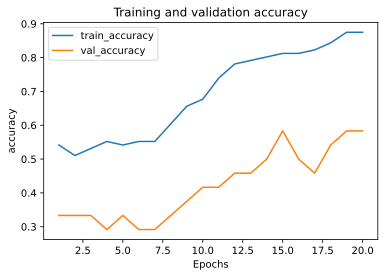

In [ ]:
plot_metric(history, 'accuracy')

### Evaluate local model of Client 2 on test data

In [ ]:
score = model.evaluate(x=x_test, y=y_test)
print('Accuracy of local model (Client 2): ', score[1])

2/2 [==============================] - 2s 56ms/step - loss: 0.6234 - accuracy: 0.6250
Accuracy of local model (Client 2):  0.625


## Load data of Client 3

In [ ]:
batch_size = 10000 #Set batch size to large number so that all images are processed in one batch

train_ds_client3 = tf.keras.preprocessing.image_dataset_from_directory(
  directory='drive/MyDrive/data/client3', 
  validation_split=0.2,
  subset="training",
  image_size=(224,224), 
  shuffle=True,
  seed=123,
  batch_size=batch_size)

val_ds_client3 = tf.keras.preprocessing.image_dataset_from_directory(
  directory='drive/MyDrive/data/client3',
  validation_split=0.2,
  subset="validation",
  image_size=(224,224), 
  shuffle=True,
  seed=123,
  batch_size=batch_size)



Found 120 files belonging to 2 classes.
Using 96 files for training.
Found 120 files belonging to 2 classes.
Using 24 files for validation.


### Prepare data

In [ ]:
  x_train_client3 = None
  y_train_client3 = None
  for image, label in tfds.as_numpy(train_ds_client3):
      x_train_client3 = image
      y_train_client3 = label

  x_val_client3 = None
  y_val_client3 = None
  for image, label in tfds.as_numpy(val_ds_client3):
      x_val_client3 = image
      y_val_client3 = label

  # Adjust shape of labels
  y_train_client3 = np.reshape(y_train_client3, (-1, 1))
  y_val_client3 = np.reshape(y_val_client3, (-1, 1))

### Fine-tune EfficientNet

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet", classes=2)

base_model.trainable = True

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2,activation="softmax")(x)
model = keras.Model(inputs, outputs)

### Compile and train model

In [ ]:
epochs = 20

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = model.fit(x=x_train_client3, y=y_train_client3, batch_size=12, epochs=epochs, shuffle=True, validation_data=(x_val_client3, y_val_client3))

Epoch 1/20
8/8 [==============================] - 12s 486ms/step - loss: 0.7200 - accuracy: 0.5104 - val_loss: 0.7489 - val_accuracy: 0.3333
Epoch 2/20
8/8 [==============================] - 2s 271ms/step - loss: 0.6784 - accuracy: 0.5938 - val_loss: 0.7877 - val_accuracy: 0.3333
Epoch 3/20
8/8 [==============================] - 2s 270ms/step - loss: 0.6586 - accuracy: 0.5625 - val_loss: 0.7381 - val_accuracy: 0.3750
Epoch 4/20
8/8 [==============================] - 2s 269ms/step - loss: 0.6378 - accuracy: 0.6354 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 5/20
8/8 [==============================] - 2s 264ms/step - loss: 0.6210 - accuracy: 0.6771 - val_loss: 0.6789 - val_accuracy: 0.5417
Epoch 6/20
8/8 [==============================] - 2s 269ms/step - loss: 0.6061 - accuracy: 0.7396 - val_loss: 0.6652 - val_accuracy: 0.5417
Epoch 7/20
8/8 [==============================] - 2s 264ms/step - loss: 0.5872 - accuracy: 0.7604 - val_loss: 0.6534 - val_accuracy: 0.5417
Epoch 8/20
8/8 [===

### Plot training and validation accuracy

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

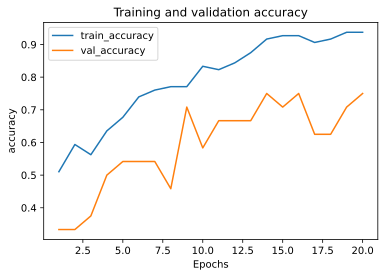

In [ ]:
plot_metric(history, 'accuracy')

### Evaluate local model of Client 3 on test data

In [ ]:
score = model.evaluate(x=x_test, y=y_test)
print('Accuracy of local model (Client 3): ', score[1])

2/2 [==============================] - 2s 57ms/step - loss: 0.6718 - accuracy: 0.5750
Accuracy of local model (Client 3):  0.574999988079071
